In [194]:
%reset -f

In [195]:
import pandas as pd
from sklearn.preprocessing import StandardScaler



X = pd.read_csv('train_call.tsv', sep='\t')
y = pd.read_csv('train_clinical.txt', sep='\t', index_col=0)

X = X.transpose()
X = X.tail(-4)
class_mapping = {'HER2+': 1, 'HR+': 2, 'Triple Neg': 3}
y = y.replace(class_mapping)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled)


In [196]:
from sklearn.model_selection import train_test_split


X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
import pickle

def rf_feature_selection(X_train, X_val, X_test, y_train, y_val):
    feature_names = X_train.columns.tolist()

    # First, use a RandomForest with default parameters to select features
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train.values.ravel())
    feature_importances = rf.feature_importances_

    # Select top features
    n_val = range(60, 140)
    cv_scores = []
    for n in n_val:
        top_n_indices = np.argsort(feature_importances)[-n:]
        X_train_selected = X_train.iloc[:, top_n_indices]
        cv_score = np.mean(cross_val_score(rf, X_train_selected, y_train.values.ravel(), cv=10, scoring='accuracy'))
        cv_scores.append(cv_score)

    optimal_n_rf = n_val[np.argmax(cv_scores)]
    best_features_indices = np.argsort(feature_importances)[-optimal_n_rf:]
    best_features_names = [feature_names[i] for i in best_features_indices]

    # Reduce datasets to selected features
    X_train_selected = X_train.iloc[:, best_features_indices]
    X_val_selected = X_val.iloc[:, best_features_indices]
    X_test_selected = X_test.iloc[:, best_features_indices]

    # Then, do hyperparameter tuning
    param_grid = {
        'n_estimators': [250, 275, 300, 325, 350],
        'max_depth': [15, 16, 17, 18, 19, 20, 22, 25],
        'min_samples_split': [3, 4, 5, 6, 7, 8, 9],
        'min_samples_leaf': [1, 2, 3],
        'bootstrap': [True]
    }

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_selected, y_train.values.ravel())

    print(f"Best parameters: {grid_search.best_params_}")
    best_rf = grid_search.best_estimator_

    best_rf.fit(X_train_selected, y_train.values.ravel())
    y_val_pred = best_rf.predict(X_val_selected)
    accuracy = accuracy_score(y_val.values.ravel(), y_val_pred)

    # Save the features
    with open('best_features.pkl', 'wb') as f:
        pickle.dump(best_features_names, f)

    print(f"Optimal n: {optimal_n_rf}")
    print(f"Validation accuracy: {accuracy}")
    print(f"Best features: {best_features_names}")

    return optimal_n_rf, X_train_selected, X_val_selected, X_test_selected

In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


class ModelCreator:
    def __init__(self, optimal_n):
        self.optimal_n = optimal_n

    def create_model(self, neurons, l2_value1, l2_value2):
        model = Sequential()
        model.add(Dense(neurons, input_shape=(self.optimal_n,), activation='relu', kernel_regularizer=l2(l2_value1)))
        model.add(Dense(3, activation='softmax', kernel_regularizer=l2(l2_value2)))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model


def one_hot_encode(y_trainval, y_test, y_val, y_train):
    y_trainval = to_categorical(y_trainval - 1, num_classes=3)
    y_test = to_categorical(y_test - 1, num_classes=3)
    y_val = to_categorical(y_val - 1, num_classes=3)
    y_train = to_categorical(y_train - 1, num_classes=3)
    return y_trainval, y_test, y_val, y_train


def get_keras_classifier(optimal_n):
    model_creator = ModelCreator(optimal_n)  # create an instance of ModelCreator
    return KerasClassifier(build_fn=model_creator.create_model, epochs=70, batch_size=16, verbose=0)

In [199]:
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import accuracy_score


def grid_search(model, X_train_selected, y_train):
    param_grid = {
        'neurons': [16, 32, 64, 128],
        'l2_value1': [0.0001, 0.001, 0.01, 0.1],
        'l2_value2': [0.0001, 0.001, 0.01, 0.1]
    }
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=10, verbose=2)
    grid_result = grid.fit(X_train_selected, y_train)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    return grid_result


def train_model(grid_result, optimal_n, X_train_selected, y_train, X_val_selected, y_val):
    best_n_neurons = grid_result.best_params_['neurons']
    best_l2_value1 = grid_result.best_params_['l2_value1']
    best_l2_value2 = grid_result.best_params_['l2_value2']
    print(best_n_neurons, best_l2_value1, best_l2_value2, optimal_n)

    model_creator = ModelCreator(optimal_n)
    best_model = model_creator.create_model(neurons=best_n_neurons, l2_value1=best_l2_value1, l2_value2=best_l2_value2)

    history = best_model.fit(X_train_selected, y_train, epochs=30, batch_size=16, verbose=1, validation_data=(X_val_selected, y_val))

    return best_model, history


def test_model(best_model, X_test_selected, y_test):
    y_pred = np.argmax(best_model.predict(X_test_selected), axis=-1)
    y_test = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test accuracy: {accuracy:.3f}")

    # class_report = classification_report(y_test, y_pred)
    # print("Classification Report:\n", class_report)


In [200]:
optimal_n, X_train_selected, X_val_selected, X_test_selected = rf_feature_selection(X_train, X_val, X_test, y_train, y_val)
creator = ModelCreator(optimal_n)

Best parameters: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 275}
Optimal n: 76
Validation accuracy: 0.6875
Best features: [2746, 2596, 857, 559, 1484, 2725, 1015, 1757, 2206, 851, 2422, 782, 2153, 2733, 1734, 823, 841, 1105, 474, 853, 2128, 2212, 1266, 865, 2017, 2205, 992, 1906, 620, 1113, 854, 385, 856, 94, 2663, 387, 2219, 2209, 1662, 2763, 1306, 1000, 2753, 2740, 1897, 2224, 160, 390, 2068, 833, 1651, 845, 384, 1063, 1871, 1009, 850, 721, 1480, 2210, 848, 484, 386, 175, 852, 1677, 1118, 485, 2214, 2771, 2211, 2751, 849, 2213, 844, 2184]


In [201]:
# Setup NN
y_trainval, y_test, y_val, y_train = one_hot_encode(y_trainval, y_test, y_val, y_train)
model = get_keras_classifier(optimal_n)

# Train and test
grid_result = grid_search(model, X_train_selected, y_train)

X_combined = pd.concat([X_train_selected, X_val_selected], ignore_index=True)
y_combined = np.concatenate((y_train, y_val), axis=0)

best_model, history = train_model(grid_result, optimal_n, X_train_selected, y_train, X_val_selected, y_val)
test_model(best_model, X_test_selected, y_test)

C:\Users\nikos\AppData\Local\Temp\ipykernel_13524\3749697413.py:30: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  return KerasClassifier(build_fn=model_creator.create_model, epochs=70, batch_size=16, verbose=0)


Fitting 10 folds for each of 64 candidates, totalling 640 fits
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.6s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.6s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.6s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.6s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.7s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.7s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.7s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.6s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.7s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=16; total time=   0.6s
[CV] END .....l2_value1=0.0001, l2_value2=0.0001, neurons=32; total time=   0.6s
[CV] END .....l2_value1=0.0001, l2_value2=0.00

In [202]:
# Evaluate the model on the test set
y_pred = np.argmax(best_model.predict(X_test_selected), axis=-1)
y_test = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy:.3f}")

1/1 [==============================] - 0s 9ms/step
Test accuracy: 0.800


In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

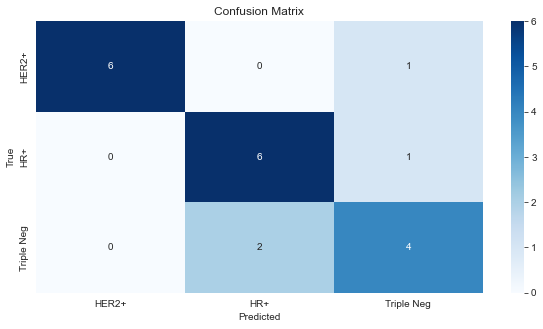

In [204]:
# Calculate and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_mapping.keys(), yticklabels=class_mapping.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

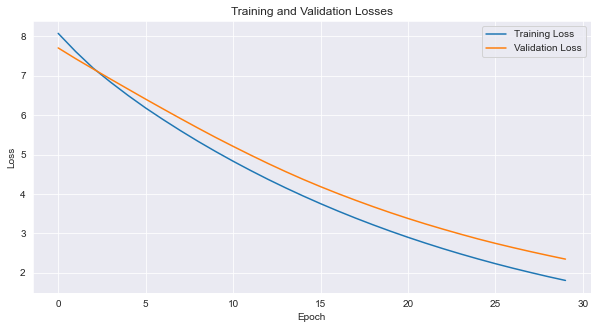

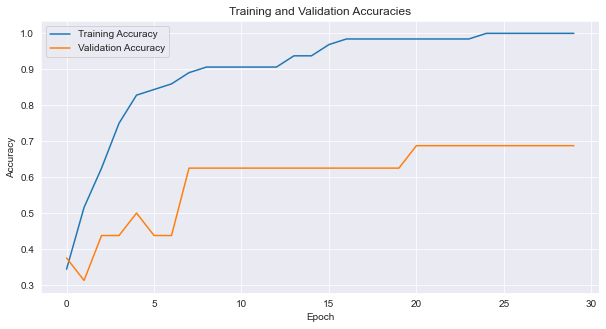

In [205]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

In [206]:
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.86      0.92         7
           1       0.75      0.86      0.80         7
           2       0.67      0.67      0.67         6

    accuracy                           0.80        20
   macro avg       0.81      0.79      0.80        20
weighted avg       0.81      0.80      0.80        20

